In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

import os
import tarfile
import urllib

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

(-0.5, 27.5, 27.5, -0.5)

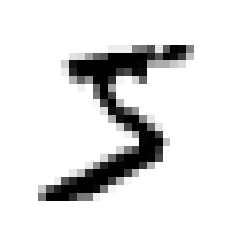

In [7]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8)

In [10]:
train_size = 60000

In [11]:
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

now we dealing with skewed dataset, that's whyaccuract is not the preferred performance measure for calssifiers

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [22]:
from sklearn.metrics import precision_score, recall_score
print(f"precision - {precision_score(y_train_5, y_train_pred)}, recall - {recall_score(y_train_5, y_train_pred)}")

precision - 0.8370879772350012, recall - 0.6511713705958311


In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [24]:
y_scores = sgd_clf.decision_function([some_digit])

In [25]:
y_scores

array([2164.22030239])

In [26]:
threshold = 0

In [27]:
y_some_digit_pred = (y_scores > threshold)

In [28]:
y_some_digit_pred

array([ True])

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [31]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

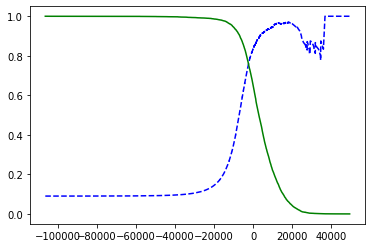

In [32]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [33]:
threshold_90_precision = thresholds[np.argmax(precisions >= 90)]

In [34]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.0904012273621719

In [36]:
recall_score(y_train_5, y_train_pred_90)

1.0

In [37]:
from sklearn.metrics import roc_curve

In [38]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

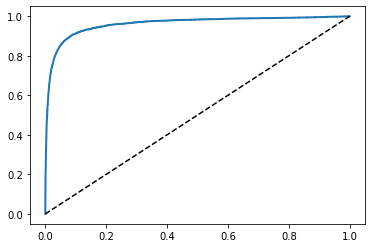

In [40]:
plot_roc_curve(fpr, tpr)

In [41]:
from sklearn.metrics import roc_auc_score

In [42]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

/home/vlad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vlad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vlad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [44]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

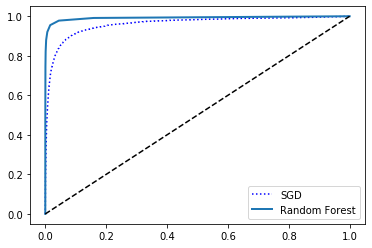

In [45]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

```python
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
```

```python
svm_clf.predict([some_digit])
```

```python
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
np.argmax(some_digit_scores)
svm_clf.classes_
svm_clf.classes_[5]

```

In [47]:
from sklearn.multiclass import OneVsRestClassifier

In [49]:
from sklearn.svm import SVC

In [ ]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

/home/vlad/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
